In [1]:
!pip install tensorflow keras

  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl (26.4 MB)
   ---------------------------------------- 0.0/896.1 kB ? eta -:--:--
   ------ --------------------------------- 143.4/896.1 kB 2.8 MB/s eta 0:00:01
   -------------------------------- ------- 727.0/896.1 kB 7.6 MB/s eta 0:00:01
   ---------------------------------------- 896.1/896.1 kB 8.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 47.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [2]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [6]:
#  Loading and Preparing the Dataset

import pandas as pd

# Load the datasets
fake_data = pd.read_csv('Data/DataSet_Misinfo_FAKE.csv')
true_data = pd.read_csv('Data/DataSet_Misinfo_TRUE.csv')

# Add a 'label' column: 0 for fake, 1 for true
fake_data['label'] = 0
true_data['label'] = 1

# Combine the datasets
df = pd.concat([fake_data, true_data])

# Shuffle the combined dataset
df = df.sample(frac=1).reset_index(drop=True)

# Extract the texts and labels
texts = df['text'].values
labels = df['label'].values


In [9]:
# Text Preprocessing for Deep Learning

# Convert all non-string values to empty strings
df['text'] = df['text'].fillna('').astype(str)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialize tokenizer
tokenizer = Tokenizer()

# Fit the tokenizer on the text data
tokenizer.fit_on_texts(df['text'].values)

# Convert texts to sequences
sequences = tokenizer.texts_to_sequences(df['text'].values)

# Padding the sequences, setting maxlen to 500
data = pad_sequences(sequences, maxlen=500)

# Check the shape of the padded data
print("Shape of data:", data.shape)



Shape of data: (78617, 500)


In [10]:
# Building the Neural Network

# Define the model
model = keras.Sequential([
    keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=500),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(data, labels, epochs=5, batch_size=32, validation_split=0.2)



Epoch 1/5
1966/1966 [==============================] - 149s 76ms/step - loss: 0.1445 - accuracy: 0.9458 - val_loss: 0.0821 - val_accuracy: 0.9703
Epoch 2/5
1966/1966 [==============================] - 149s 76ms/step - loss: 0.0209 - accuracy: 0.9946 - val_loss: 0.0780 - val_accuracy: 0.9723
Epoch 3/5
1966/1966 [==============================] - 149s 76ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 0.0905 - val_accuracy: 0.9695
Epoch 4/5
1966/1966 [==============================] - 149s 76ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.1054 - val_accuracy: 0.9706
Epoch 5/5
1966/1966 [==============================] - 149s 76ms/step - loss: 0.0018 - accuracy: 0.9998 - val_loss: 0.1098 - val_accuracy: 0.9704


In [11]:
# Evaluating the Model

loss, accuracy = model.evaluate(data, labels)
print(f'Accuracy: {accuracy * 100:.2f}%')



2457/2457 [==============================] - 2s 948us/step - loss: 0.0226 - accuracy: 0.9941
Accuracy: 99.41%


In [12]:
# Train/Test Split to verify results

from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Train the model on training data
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/5
1573/1573 [==============================] - 119s 76ms/step - loss: 0.0259 - accuracy: 0.9932 - val_loss: 0.0383 - val_accuracy: 0.9889
Epoch 2/5
1573/1573 [==============================] - 118s 75ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0266 - val_accuracy: 0.9932
Epoch 3/5
1573/1573 [==============================] - 120s 76ms/step - loss: 4.8043e-04 - accuracy: 0.9999 - val_loss: 0.0260 - val_accuracy: 0.9944
Epoch 4/5
1573/1573 [==============================] - 120s 76ms/step - loss: 3.5445e-04 - accuracy: 0.9999 - val_loss: 0.0289 - val_accuracy: 0.9932
Epoch 5/5
492/492 [==============================] - 0s 951us/step - loss: 0.0279 - accuracy: 0.9932
Test Accuracy: 99.32%


In [13]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import numpy as np

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)  # Round predictions to nearest integer (0 or 1)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
print("Confusion Matrix:\n", cm)


492/492 [==============================] - 0s 804us/step
Confusion Matrix:
 [[8643   61]
 [  46 6974]]


In [14]:
# Precision, Recall, and F1-Score

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred_classes, target_names=['Fake', 'True'])
print(report)


              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      8704
        True       0.99      0.99      0.99      7020

    accuracy                           0.99     15724
   macro avg       0.99      0.99      0.99     15724
weighted avg       0.99      0.99      0.99     15724



In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

# Assuming y_test are the actual labels and y_pred are the predicted labels (after rounding probabilities)
y_pred = np.round(model.predict(X_test))

# Calculate Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1-Score
f1 = f1_score(y_test, y_pred)
print(f'F1-Score: {f1:.4f}')

# Calculate AUC-ROC
y_pred_proba = model.predict(X_test)  # Get predicted probabilities
auc_roc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC: {auc_roc:.4f}')


492/492 [==============================] - 0s 664us/step
Accuracy: 0.9932
Precision: 0.9913
Recall: 0.9934
F1-Score: 0.9924
492/492 [==============================] - 0s 699us/step
AUC-ROC: 0.9993


492/492 [==============================] - 0s 694us/step


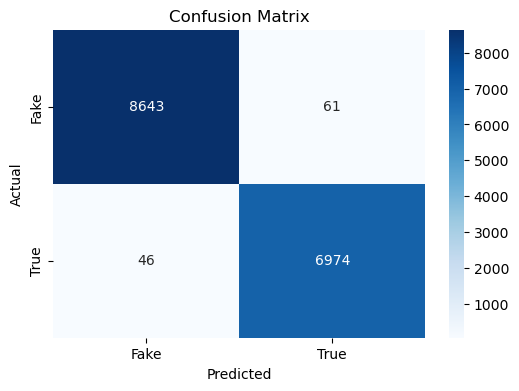

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test are the true labels and y_pred are the predicted labels
y_pred = np.round(model.predict(X_test))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix using Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [17]:
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np

# Function to build the model (required for GridSearchCV)
def build_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(64, input_dim=500, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model so it can be used in GridSearchCV
model = KerasClassifier(build_fn=build_model, epochs=5, batch_size=32, verbose=0)

# Define the hyperparameters to tune
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'dropout_rate': [0.3, 0.5, 0.7],
    'batch_size': [32, 64],
    'epochs': [5, 10]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and best accuracy
print(f"Best Accuracy: {grid_result.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_result.best_params_}")


C:\Users\belgr\AppData\Local\Temp\ipykernel_1976\661973962.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, epochs=5, batch_size=32, verbose=0)


Best Accuracy: 0.5561
Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 10, 'optimizer': 'adam'}


In [18]:
!pip install transformers datasets


In [19]:
import pandas as pd
from transformers import BertTokenizer

# Load your dataset
df = pd.read_csv('data.csv')

# Texts and labels
texts = df['text'].tolist()
labels = df['label'].tolist()

# Load pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts for BERT input
inputs = tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors='tf')


C:\Users\belgr\anaconda3\envs\mcafee\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FileNotFoundError: [Errno 2] No such file or directory: 'data.csv'